In [1]:
1+1

2

In [2]:
include("src/gravlens.jl");

In [3]:
const mvir = 200.0
const rscale = 10.0
const rvir = 200.0
const GC = G/C/C
m(r) = tnfw_m(mvir, rscale, r, rvir);
rho(r) = tnfw_ρ(mvir, rscale, r, rvir);
vc2(r) = G*m(r)/r
pressure(r) = 0.5*rho(r)*vc2(r);
A(r) = 1./(1-2*GC*m(r)/r);
function calc_tr_un(r)
    a,b = quadgk(r->sqrt(A(r))/r,rvir,r, reltol=1e-27, abstol=1.0e-27)
    exp(a)
end
function calc_tr_sch(r)
    sr = sqrt(r)
    (0.5*(sr+sqrt(r-4*(GC*mvir/2))))^2
end
const r_fac = calc_tr_sch(200.0e7)/calc_tr_un(200.0e7)
function calc_tr(r)
    r_fac.*calc_tr_un(r)
end
b_integrand(r) = 2*GC/r/r*m(r)*A(r);
B(r) = exp(-quadgk(b_integrand, r, 1.0e10, reltol=1e-18, abstol=1e-18)[1]);
bp_integrand(r) = 2*GC/r/r*(m(r)+4*π*r*r*r*pressure(r)/C/C)*A(r);
Bp(r) = exp(-quadgk(bp_integrand, r, 1.0e10, reltol=1e-18, abstol=1e-18)[1]);

In [4]:
r = 10.^linspace(log10(0.1), log10(5.0e6), 10000);
tr = open("tr.data","r") do f
    tr = zeros(10000)
    read!(f, tr)
    tr
end;
# tr = [Float64(calc_tr(big(ri))) for ri in r];
# open("tr.data","w") do f
#    write(f, tr)
# end;

const spl = Spline1D(tr, r, k=5, bc="extrapolate");
fast_r(tr) = evaluate(spl, tr);

In [5]:
function new_fermat(feta, fdeta, rs, tgα, N=100; reltol=1e-21, abstol=1e-21, ext=1.0)
    function f(x,yvec)
        (y, v) = yvec
        y_prime = v

        r = sqrt(x*x+y*y)
        eta = feta(r)
        deta = fdeta(r)
        y_prime2 = y_prime*y_prime
        yp1 = y_prime2+1.0
        
        _a = 1-y_prime2/yp1
        _b = deta/eta/r*(yp1*y - y_prime*x)
        v_prime = _b/_a
        [y_prime, v_prime]
    end
    _x = linspace(0.0,1,div(N,2)).^2
    _l = [-reverse(_x)*rs ; _x*rs.*ext]
    x, u = ode45(f, [0.0; tgα], _l; reltol=reltol, abstol=abstol)
    y = map(u -> u[1], u);
    dy = map(u -> u[2], u);
    x,y
end
function interp1(x,y,x1)
    i = searchsortedfirst(x,x1)-1
    i<1 && return y[1]
    i>=length(x) && return y[end]
    
    xi = x[i]
    xf = x[i+1]
    yi = y[i]
    yf = y[i+1]
   
    return yi+(yf-yi)/(xf-xi)*(x1-xi)
end
function interp_arr(x,y,x1)
    [interp1(x,y,xi) for xi in x1]
end
function born_fermat(feta, fdeta, fyx, rs, tgα, N=100; reltol=1e-21, abstol=1e-21, ext=1.0)
    function f(x,yvec)
        (y, v) = yvec
        y_prime = v

        y = fyx(x)
        #y = (x+rs)*tgα
        r = sqrt(x*x+y*y)
        eta = feta(r)
        deta = fdeta(r)
        y_prime2 = y_prime*y_prime
        yp1 = y_prime2+1.0
        
        _a = 1-y_prime2/yp1
        _b = deta/eta/r*(yp1*y - y_prime*x)
        v_prime = _b/_a
        [y_prime, v_prime]
    end
    _x = linspace(0.0,1,div(N,2)).^2
    _l = [-reverse(_x)*rs ; _x*rs.*ext]
    x, u = ode45(f, [0.0; tgα], _l; reltol=reltol, abstol=abstol)
    y = map(u -> u[1], u);
    dy = map(u -> u[2], u);
    x,y
end

born_fermat (generic function with 2 methods)

In [6]:
function Ltr(tr)
    const r = fast_r(tr)    
    const g = r.*r./tr./tr
    const f = B(r)
    Float64(sqrt(g./f))
end
r = 10.^linspace(log10(1.0), log10(4.99e6), 10000);
_ltr = [Float64(Ltr(big(ri))) for ri in r];
const spl_ltr = Spline1D(r, _ltr, k=5, bc="extrapolate");
fast_ltr(r) = evaluate(spl_ltr, r);
fast_dltr(r) = derivative(spl_ltr, r);

rs = 1.0e6
b = 3.0
tgα = b/rs
N = 1000000
x, y = new_fermat(fast_ltr, fast_dltr, rs, tgα, N; reltol=1e-17, abstol=1e-17);

In [7]:
function Ltrp(tr)
    const r = fast_r(tr)    
    const g = r.*r./tr./tr
    const f = Bp(r)
    Float64(sqrt(g./f))
end
r = 10.^linspace(log10(1.0), log10(4.99e6), 10000);
_ltrp = [Float64(Ltr(big(ri))) for ri in r];
const spl_ltrp = Spline1D(r, _ltrp, k=5, bc="error");
fast_ltrp(r) = evaluate(spl_ltrp, r);
fast_dltrp(r) = derivative(spl_ltrp, r);

rs = 1.0e6
b = 3.0
tgα = b/rs
N = 1000000
xp, yp = new_fermat(fast_ltrp, fast_dltrp, rs, tgα, N; reltol=1e-17, abstol=1e-17);

In [8]:
θ = 0.0
nx,ny,_ = numeric_el(m, rho, θ, rs, tgα, N; abstol=1.0e-17, reltol=1.0e-17, ϕm=π);
ixs = find(abs(nx).<rs);
nx = nx[ixs]
ny = ny[ixs];

In [9]:
phi(r) = tnfw_potential(mvir, rscale, r, rvir)/C/C;
r = 10.^linspace(log10(1.0), log10(4.99e6), 10000);

In [10]:
_eta = [1-2*Float64(phi(ri)) for ri in r];
const spl_eta = Spline1D(r, _eta, k=5, bc="error");
fast_eta(r) = evaluate(spl_eta, r);
fast_deta(r) = derivative(spl_eta, r);

In [11]:
rs = 1.0e6
b = 3.0
tgα = b/rs
N = 1000000
const (x1, y1) = new_fermat(fast_eta, fast_deta, rs, tgα, N; reltol=1e-17, abstol=1e-17);

const _xx = deepcopy(x1)
const _yy = (_xx-_xx[1])*tgα
fyx1(x) = interp1(_xx, _yy, x);
x1b, y1b = born_fermat(fast_eta, fast_deta, fyx1, rs, tgα, N; reltol=1e-17, abstol=1e-17);

In [12]:
const _xx2 = deepcopy(x1b)
const _yy2 = deepcopy(y1b)
fyx2(x) = interp1(_xx2, _yy2, x);
x2b, y2b = born_fermat(fast_eta, fast_deta, fyx2, rs, tgα, N; reltol=1e-17, abstol=1e-17);

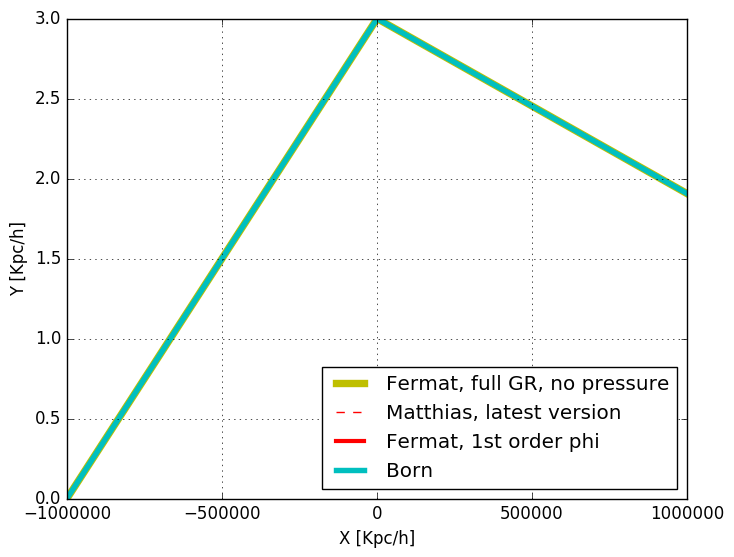

PyObject <matplotlib.legend.Legend object at 0x7f4f984c0be0>

In [23]:
plot(x,y,"-y", lw=5.3, label="Fermat, full GR, no pressure")
hold(true)
plot(nx,ny,"--r", label="Matthias, latest version")
plot(x1,y1,"-r",lw=3.0, label="Fermat, 1st order phi")
#plot(xp,yp,"-k", label="Fermat, full GR, pressure")
plot(x1b,y1b,"-c", lw=3.9, label="Born")
#plot(x1b,y1b,"-y", lw=3.9, label="Born")
#xlim(-100,150)
#ylim(2.9997,3.00013)
grid(true)
xlabel("X [Kpc/h]")
ylabel("Y [Kpc/h]")
legend(loc=4)

In [24]:
function get_angle(x0,y0, x1,y1)
    dx = x1-x0
    dy = y1-y0
    atan2(dy,dx)
end
function ray_deflection(x,y)
    get_angle(x[5],y[5], x[10],y[10]) - get_angle(x[end-10],y[end-10], x[end-5],y[end-5])
end

ray_deflection (generic function with 1 method)

In [15]:
d = ray_deflection(x,y)

4.0941023780685905e-6

In [16]:
d1 = ray_deflection(x1,y1)

4.094070250461133e-6

In [17]:
d1b = ray_deflection(x1b,y1b)

4.0941033158306596e-6

In [18]:
d2b = ray_deflection(x2b,y2b)

4.0940702520709775e-6

In [19]:
(d-d1b)/d

-2.2905193434299056e-7

In [20]:
(d-d1)/d

7.847289708626458e-6

In [21]:
(d-d2b)/d

7.846896497999838e-6